In [1]:
import data_utils as util
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

In [ ]:
%matplotlib notebook

# data preprocessing

In [2]:
#######################################################
# Load the feature header
#######################################################
import csv

# read the csv file
feature_names = []
with open('./data/header.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        feature_names.append(line)

# Dirty tricks to clean up the feature names
feature_names = feature_names[0]
feature_names = list(map(lambda x: x.replace(' ', '_'), feature_names))
feature_names[0] = 'PharmGKB_Subject_ID' # manual fix to remove a character in f...[0]

In [3]:
####################################################################
# Load the dataframe into X; clean up some unnecessary columns 
####################################################################

# Load data and process column names
df = pd.read_csv('./data/warfarin_with_dose.csv', names = feature_names)
#keep_default_na=False)
df.columns = [c.replace(' ', '_') for c in df.columns]

# Extract the label (Warfarin dose) from the rest of the features
y = df.Therapeutic_Dose_of_Warfarin
X = df.drop('Therapeutic_Dose_of_Warfarin',axis=1)
feature_names.remove('Therapeutic_Dose_of_Warfarin')

# Drop Subject_ID (irrelevant) and Medication (different to encode)
X = X.drop('PharmGKB_Subject_ID',axis=1)
X = X.drop('Medications',axis=1)
X = X.drop('Comorbidities',axis=1)
feature_names.remove('PharmGKB_Subject_ID')
feature_names.remove('Medications')
feature_names.remove('Comorbidities')

In [4]:
####################################################################
# Encode different features with numeric/label/onehot encodings 
####################################################################
numeric_features = ['Height_(cm)',
                    'Weight_(kg)',
                    'Target_INR',
                    'INR_on_Reported_Therapeutic_Dose_of_Warfarin',
                    ]
label_features =   ['Age',
                    'Estimated_Target_INR_Range_Based_on_Indication']
categorical_features = [f for f in feature_names \
                        if f not in numeric_features and f not in label_features]

for feat in categorical_features:
    X[feat] = X[feat].astype(str)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='0-missing')),
    ('ordinal', OrdinalEncoder())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('lab', label_transformer, label_features),
        ('cat', categorical_transformer, categorical_features)]
)


In [6]:
X_transformed = preprocessor.fit_transform(X)

In [7]:
X_transformed.shape

(5528, 259)

In [8]:
#X.shape

# Train Validation Test Split

In [8]:
# Split the data into train, val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state = 5)

# Learning

In [9]:
# Linear regression
from sklearn.linear_model import LinearRegression

lr_regressor = LinearRegression(fit_intercept = True)
lr_regressor.fit(X_train, y_train)
print(lr_regressor.score(X_val, y_val))
print(lr_regressor.score(X_train, y_train))

y_pred = lr_regressor.predict(X_val)
print(mean_squared_error(y_val,y_pred))
print(np.mean(y_val))
coef = lr_regressor.coef_
print(coef)




-8.191186321644581e+17
0.4912769925082705
2.4616284861531695e+20
31.52241807909605
[ 1.03762222e+00  3.85513292e+00  3.98436247e-01  5.84098322e-01
 -2.16153503e+00 -1.91481316e-01 -1.73157801e+12 -1.73157801e+12
 -1.73157801e+12  2.47473474e+11  2.47473474e+11  2.47473474e+11
  2.47473474e+11  7.62698577e+11  7.62698577e+11  7.62698577e+11
 -2.77169281e+09 -2.77169281e+09 -2.70410457e+11 -2.77169281e+09
 -2.77169281e+09 -7.25682033e+09 -2.77169281e+09 -2.77169282e+09
 -2.77169281e+09  2.45262330e+11 -2.77169282e+09 -2.77169281e+09
 -2.34518760e+10 -2.77169281e+09 -2.77169281e+09 -2.77169280e+09
 -1.76490996e+10 -2.77169282e+09 -2.77169282e+09 -2.77169282e+09
 -2.77169282e+09 -2.77169281e+09  3.17039372e+10 -2.77169282e+09
 -2.77169281e+09 -2.77169283e+09 -2.77169281e+09 -2.77169281e+09
 -2.77169282e+09 -2.77169284e+09 -2.77169282e+09 -2.77169282e+09
 -2.77169283e+09 -2.77169282e+09 -2.77169282e+09 -2.77169282e+09
 -2.77169283e+09 -2.77169282e+09 -2.77169281e+09 -2.77169279e+09
 -2.771

In [ ]:
# SVM
from sklearn.svm import SVR

svm_regressor = SVR(kernel='rbf', gamma='auto')
svm_regressor.fit(X_train, y_train)
svm_regressor.score(X_val, y_val)

In [ ]:
# SVM with various hyperparameters
from sklearn.svm import SVR

#initialise arrays to store the scores 
svm_score_train = np.zeros((7,1))
svm_score_val = np.zeros((7,1))

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    svm_regressor = SVR(kernel='rbf', gamma='auto', C=C)
    svm_regressor.fit(X_train,y_train)
    svm_score_train[i,:] = svm_regressor.score(X_train,y_train)
    svm_score_val[i,:] = svm_regressor.score(X_val,y_val)
    
print('training score \n', svm_score_train)
print('validation score \n', svm_score_val)




In [11]:
# Ridge Regression
from sklearn.linear_model import Ridge

#initialise arrays to store the scores 
ridge_score_train = np.zeros(7)
ridge_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    ridge_regressor = Ridge(alpha=1/C, fit_intercept = True)
    ridge_regressor.fit(X_train,y_train)
    ridge_score_train[i] = ridge_regressor.score(X_train,y_train)
    ridge_score_val[i] = ridge_regressor.score(X_val,y_val)
    
print('training score \n', ridge_score_train)
print('validation score \n', ridge_score_val)

best_ridge = Ridge(alpha = 1, fit_intercept = True)
best_ridge.fit(X_train,y_train)
y_pred = best_ridge.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,y_pred)))
# print(np.mean(y_val))

# print(best_ridge.coef_)

training score 
 [0.49127676 0.49127608 0.49122248 0.48984508 0.48414958 0.4677943
 0.42004327]
validation score 
 [0.44686551 0.44705458 0.44862756 0.45435222 0.45738596 0.44720356
 0.41238118]
12.805426482489523


In [ ]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,ridge_score_train, label = 'training')
plt.plot(xaxis,ridge_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('score')
plt.legend()
plt.xscale('log')
plt.title('Accuracy vs Lambda - Ridge Penalty')
plt.savefig('Ridge.png')

In [12]:
# Lasso Regression
from sklearn.linear_model import Lasso

#initialise arrays to store the scores 
lasso_score_train = np.zeros(7)
lasso_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    lasso_regressor = Lasso(alpha=1/C, fit_intercept = True)
    lasso_regressor.fit(X_train,y_train)
    lasso_score_train[i] = lasso_regressor.score(X_train,y_train)
    lasso_score_val[i] = lasso_regressor.score(X_val,y_val)
    
print('training score \n', lasso_score_train)
print('validation score \n', lasso_score_val)

best_lasso = Lasso(alpha = 0.01, fit_intercept = True)
best_lasso.fit(X_train,y_train)
y_pred = best_lasso.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,y_pred)))
# print(np.mean(y_val))

# print(best_lasso.coef_)

C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


training score 
 [0.49057317 0.482041   0.44870825 0.34330584 0.         0.
 0.        ]
validation score 
 [ 0.45273163  0.45458929  0.42456451  0.34166222 -0.00081468 -0.00081468
 -0.00081468]
12.802644426578187


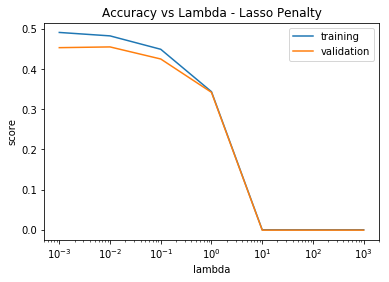

In [15]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,lasso_score_train, label = 'training')
plt.plot(xaxis,lasso_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('score')
plt.legend()
plt.xscale('log')
plt.title('Accuracy vs Lambda - Lasso Penalty')
plt.savefig('Lasso.png')

In [14]:
import exp_util

In [15]:
exp_util.val_bin_accuracy(lr_regressor, X_val, y_val)

0.672316384180791

In [16]:
exp_util.val_bin_accuracy(best_ridge, X_val, y_val)

0.6711864406779661

In [17]:
exp_util.val_bin_accuracy(best_lasso, X_val, y_val)

0.6655367231638418

In [18]:
exp_util.val_bin_accuracy_two_classes(best_ridge, X_val, y_val)

0.7717514124293785

In [19]:
exp_util.val_bin_accuracy_two_classes(best_lasso, X_val, y_val)

0.7728813559322034

In [ ]:
# non-nested cross validation using RBF SVM
from sklearn.model_selection import GridSearchCV

rbf = SVR(kernel='rbf')
gammas = np.logspace(-6, 0, 7)
params = {'gamma': gammas}
gridcv = GridSearchCV(estimator=rbf, param_grid=params, cv=5)
gridcv.fit(X_trainval, y_trainval)
scores_mean = gridcv.cv_results_['mean_test_score']
scores_sd = gridcv.cv_results_['std_test_score']
print('highest accuracy score is',gridcv.best_score_)
model = gridcv.best_estimator_

In [ ]:
# non-nested cross validation using Ridge
from sklearn.model_selection import GridSearchCV

ridge_regressor = Ridge(fit_intercept = True)
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

gridcv = GridSearchCV(estimator=ridge_regressor, param_grid=params, cv=10)
gridcv.fit(X_trainval, y_trainval)
scores_mean = gridcv.cv_results_['mean_test_score']
scores_sd = gridcv.cv_results_['std_test_score']
print('highest accuracy score is',gridcv.best_score_)
model = gridcv.best_estimator_

In [ ]:
%matplotlib notebook